In [65]:
#Importing the required libraries

import numpy as np #linear algebra
import pandas as pd #data preprocessing
import matplotlib.pyplot as plt #plotting
%matplotlib inline
import xgboost as xgb #importing the selected algorithm
import itertools
from sklearn.model_selection import RepeatedKFold 
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score, confusion_matrix #metrics
from scipy import stats #for post-hoc statistical analysis of the important variables measured by permutation importance
from statsmodels.stats.multitest import multipletests #for the correction of multiple comparisons
from statsmodels.stats import contingency_tables
from eli5.sklearn import PermutationImportance #measuring variable importance

In [66]:
"""
Loading the dataset. Missing values were coded as -99, replacing them with NaNs.
"""
prius_df = pd.read_excel(r'~\Extremism_prediction\Data\PIRUS_v3.2_public_download.xlsx')
prius_df = prius_df.replace(['-99', -99], np.nan)

"""
Removing columns which are either irrelevant or would lead to self-evident interactions with the outcome variable
"""
to_drop1 = ['Subject_ID', 'Loc_Plot_State1', 'Loc_Plot_City1', 'Loc_Plot_State2', 'Loc_Plot_City2', 
            'Terrorist_Group_Name1', 'Terrorist_Group_Name2', 'Terrorist_Group_Name3','Plot_Target1',
            'Plot_Target2', 'Plot_Target3', 'Attack_Preparation', 'Op_Security', 
            'Changing_Target', 'Anticp_Fatals_Targ','Internet_Use_Plot','Extent_Plot', 
            'Criminal_Severity', 'Criminal_Charges', 'Indict_Arrest', 'Current_Status', 
            'Loc_Habitation_State1', 'Loc_Habitation_City1','Loc_Habitation_State2', 
            'Loc_Habitation_City2','Convert_Date','Reawakening_Date','Citizenship','Nativity',
            'Immigrant_Source', 'Date_Exposure','Previous_Criminal_Activity_Type2','Previous_Criminal_Activity_Type3',
            'Recruiter2', 'Recruiter3','Abuse_Type2','Abuse_Type3','Friendship_Source2','Friendship_Source3', 
            'Ideological_Sub_Category2', 'Ideological_Sub_Category3','Event_Influence2','Event_Influence3',
            'Event_Influence4','Social_Media_Platform2','Social_Media_Platform3','Social_Media_Platform4',
            'Social_Media_Platform5','Social_Media_Activities2','Social_Media_Activities3','Social_Media_Activities4',
            'Social_Media_Activities5','Social_Media_Activities6','Social_Media_Activities7']

prius_df.drop(to_drop1, axis = 1, inplace = True)
prius_df['Radical_Behaviors'].replace([9,10], np.nan, inplace = True)

In [67]:
"""
Checking each variable for coding mistakes by looking at the frequencies and comparing them to the original codebook.
"""

keys = [col for col in prius_df.columns]
frequencies = dict.fromkeys(keys)
for i in frequencies:
    frequencies[i] = pd.DataFrame(prius_df[i].value_counts(dropna = False))
"""
The following variables contained coding mistakes (e.g. letters instead of numbers), 
converting them into numeric with error coercion.
"""
var_list = ['Diaspora_Ties', 'Gang_Age_Joined', 'Itinerant', 'Radicalization_Place', "Radicalization_Sequence"]
prius_df[var_list] = prius_df[var_list].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [68]:
"""
Many variables included the value -88. According to the codebook, these values cannot always be considered as missing, 
so they will be recoded one-by-one on a theoretical basis. While XGBoost would handle these as distinct categories 
(-88 are only present in categorical variables), recoding them to ensure the interpretability of the results.
"""

mask = prius_df.eq(-88)
prius_list = prius_df.loc[:, mask.any()].columns

prius_df['Actively_Recruited'].replace(-88, np.nan, inplace = True)
prius_df['Recruiter1'].replace(-88, 0, inplace = True)
prius_df['Group_Competition'].replace(-88, 0, inplace = True)
prius_df['Role_Group'].replace(-88, 0, inplace = True)
prius_df['Length_Group'] = prius_df['Length_Group'].replace(-88, 0)
prius_df['Internet_Radicalization'].replace(-88, 0, inplace = True)
prius_df['Media_Radicalization'].replace(-88, np.nan, inplace = True)
prius_df['Social_Media'].replace(-88, 0, inplace = True)
prius_df['Social_Media_Frequency'].replace(-88, 0, inplace = True)
prius_df['Social_Media_Platform1'].replace(-88, 0, inplace = True)
prius_df['Social_Media_Activities1'].replace(-88, 0, inplace = True)
prius_df['Foreign_Govt_Leader'].replace(-88, np.nan, inplace = True)
prius_df['Event_Influence1'].replace(-88, np.nan, inplace = True)
prius_df['Employment_Status'].replace(-88, np.nan, inplace = True)
prius_df['Abuse_type1'].replace(-88, 0, inplace = True)
prius_df['Friendship_Source1'].replace(-88, 0, inplace = True)
prius_df['Previous_Criminal_Activity_Type1'].replace(-88, 0, inplace = True)
prius_df['Gang_Age_Joined'].replace(-88, 0, inplace = True)

prius_df['Diaspora_Ties'].replace(-88, 0, inplace = True)
prius_df['Work_History'].replace(-88, np.nan, inplace = True)
prius_df['Social_Stratum_Adulthood'].replace(-88, 0, inplace = True)
prius_df['Overseas_Family'].replace(-88, 0, inplace = True)
prius_df['Previous_Criminal_Activity_Age'].replace(-88, 0, inplace = True)

repdict = {0:1, 1:2, 2:3, -88: 0}
repdict2 = {0:1, 1:2, -88: 0}
repdict3 = {0:1, 1:2, 2:3, 3:4, -88: 0}

prius_df['Abuse_Adult'] = prius_df.Abuse_Adult.map(repdict3)
prius_df['Language_English'] = prius_df.Language_English.map(repdict2)
prius_df['Prison_Radicalize'] = prius_df.Prison_Radicalize.map(repdict3)
prius_df['Clique_Radicalize']= prius_df.Clique_Radicalize.map(repdict2)
prius_df['Clique_Connect'] = prius_df.Clique_Connect.map(repdict2)
prius_df['Education_Change'] = prius_df.Education_Change.map(repdict)
prius_df['Change_Performance'] = prius_df.Change_Performance.map(repdict2)


In [69]:
"""
Detecting multicollinearity between the predictors. ALthough XGBoost is able to handle collinear variables,
removing them makes the interpretation of the variable importance results more straightforward.
"""
keys = [col for col in prius_df.columns if col not in 'Violent']
corr_dict = dict.fromkeys(keys)
for i in corr_dict:
    corr_dict[i] = pd.DataFrame(index =['r', 'p'], columns = prius_df.columns)
    for col in prius_df.columns:
        corr_dict[i].loc[['r'], [col]] = abs(stats.spearmanr(prius_df[i],prius_df[col], nan_policy = 'omit')[0])
        corr_dict[i].loc[['p'], [col]] = stats.spearmanr(prius_df[i], prius_df[col], nan_policy = 'omit')[1]
    corr_dict[i] = corr_dict[i].transpose().sort_values(by=['r'], ascending = False)

    
#Removing collinear variables
collinears = ['Abuse_type1','Recruiter1','Clique_Connect','Clique_Radicalize','Education_Change',
              'Family_Ideological_Level','Gang_Age_Joined', 'Previous_Criminal_Activity_Age','Social_Media_Frequency',
              'Social_Media_Activities1','Social_Media_Platform1']

prius_df.drop(collinears, axis = 1, inplace =True)

In [70]:
"""
One of the purpose of the study is to identify how violence/nonviolence can be predicted with different information quantities
As such, 4 different predictor sets were created:
-A set that only contains demographic and socioeconomic variables
-A set that contains demographic, socioeconomic and personal variables
-A set that contains demographic, socioeconomic, personal and radicalization variables
-A set that contains all of the above, plus group variables (full model) 
"""

dem_soc_cols = ['Violent', 'Broad_Ethnicity', 'Age', 'Marital_Status', 'Children', 'Gender', 'Religious_Background', 'Convert', 'Reawakening','Residency_Status', 'Immigrant_Generation', 'Language_English', 'Diaspora_Ties', 'Education', 'Student', 'Employment_Status', 'Change_Performance', 'Work_History', 'Military', 'Social_Stratum_Childhood', 'Social_Stratum_Adulthood', 'Foreign_Military', 'Time_US_Months','Aspirations']
personal_cols = ['Abuse_Child', 'Abuse_Adult', 'Psychological', 'Alcohol_Drug', 'Absent_Parent', 'Overseas_Family', 'Close_Family',  'Family_Ideology', 'Prison_Family_Friend', 'Crime_Family_Friend', 'Radical_Friend', 'Radical_Signif_Other', 'Relationship_Troubles', 'Platonic_Troubles', 'Unstructured_Time', 'Friendship_Source1','Kicked_Out', 'Previous_Criminal_Activity', 'Previous_Criminal_Activity_Type1', 'Gang', 'Trauma', 'Other_Ideologies', 'Angry_US', 'Group_Grievance', 'Standing','Radical_Family','Family_Religiosity']
rad_cols = ['Internet_Radicalization', 'Media_Radicalization', 'Radicalization_Islamist', 'Rad_duration', 'Radicalization_Far_Right','Radicalization_Far_Left', 'Radicalization_Single_Issue', 'Ideological_Sub_Category1', 'Itinerant', 'External_Rad', 'Radical_Beliefs', 'US_Govt_Leader', 'Event_Influence1', 'Beliefs_Trajectory', 'Behaviors_Trajectory', 'Radicalization_Sequence', 'Radicalization_Place', 'Prison_Radicalize','Foreign_Govt_Leader','Social_Media','Radical_Behaviors' ]
group_cols = ['Group_Membership', 'Actively_Recruited','Actively_Connect', 'Group_Competition', 'Role_Group', 'Length_Group', 'Clique']
dem_soc_df = prius_df[dem_soc_cols]
dem_soc_pers_df = dem_soc_df.join(prius_df[personal_cols])
dem_soc_pers_rad_df = dem_soc_pers_df.join(prius_df[rad_cols])
dem_soc_pers_rad_group_df = dem_soc_pers_rad_df.join(prius_df[group_cols])



In [71]:
"""
Initializing the selected algorithm (XGBoost) and the cross-validation, creating the modeling function.
Instead of the traditional train/test split setup, model performance was evaluated using 10 times repeated 
10-fold cross-validation. Repeated K-fold was selected to ensure the statistical robustness of the results, 
as the dataset is relatively small.

Primary metrics were ROC-AUC and PR-AUC (due to slight class imbalance). Sensitivity and specificity were also calculated.
Variable importance was measured using permutation importance scores, 
which was shown to to be more reliable compared to traditional measures.
"""

classifier = xgb.XGBClassifier(random_state = 123)
cv = RepeatedKFold(n_splits=10, n_repeats = 10, random_state = 123)
plt.rcParams['figure.figsize'] = [18, 11]


def modelfit(data, classifier , cv, color, label):
    X = data.iloc[:,1:].values
    y = data.iloc[:,0].values
    i = 1

    tprs = []
    precisions = []
    roc_aucs = []
    pr_aucs = []
    accuracy = []
    
    result = dict()    
    result['mean_recall'] = np.linspace(0,1,100)
    result['mean_fpr'] = np.linspace(0,1,100)
    permutation_importance = []
    conf_matrix = np.zeros([2,2])

    for i, (train_index, test_index) in enumerate(cv.split(X, y)):
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        classifier.fit(Xtrain, ytrain)
        probas_ = classifier.predict_proba(Xtest)
        predictions = classifier.predict(Xtest)
        fpr, tpr, thresholds = roc_curve(ytest, probas_[:, 1])
        accuracy.append(accuracy_score(ytest, predictions))
        conf_matrix += confusion_matrix(ytest, predictions)
        
        tprs.append(np.interp(result['mean_fpr'], fpr, tpr))
        tprs[-1][0] = 0.0
        roc_aucs.append(auc(fpr, tpr))        
        precision, recall, _ = precision_recall_curve(ytest, probas_[:, 1])
        recall = np.fliplr([recall])[0]
        precision = np.fliplr([precision])[0]
        pr_aucs.append(auc(recall, precision))
        precisions.append(np.interp(result['mean_recall'], recall, precision))

        perm = PermutationImportance(classifier, scoring = 'roc_auc', random_state = 123, cv= 'prefit').fit(X[test_index], y[test_index])
        permutation_importance.append(perm.feature_importances_)
 
    mean_permutation_importance = pd.DataFrame(np.vstack(permutation_importance), columns = data.columns[1:]).transpose()
    mean_permutation_importance['Feature_mean'] = np.mean(mean_permutation_importance, axis = 1)
    mean_permutation_importance = mean_permutation_importance.sort_values(by=['Feature_mean'], ascending = False)
    
    result['mean_tpr'] = np.mean(tprs, axis = 0)
    result['roc_aucs'] = roc_aucs
    result['mean_roc_aucs'] = np.mean(roc_aucs)
    result['mean_roc_aucs_std'] = np.std(roc_aucs)
    result['sensitivity'] = conf_matrix[0,0] / (conf_matrix[0,0] + conf_matrix[0,1])
    result['specificity'] = conf_matrix[1,1] / (conf_matrix[1,1] + conf_matrix[1,0])
    
    result['mean_precision'] = np.mean(precisions, axis = 0)
    result['pr_aucs'] = pr_aucs
    result['mean_pr_aucs'] = np.mean(pr_aucs)
    result['mean_pr_aucs_std'] = np.std(pr_aucs)
    result['accuracy_std'] = np.std(accuracy)
    result['accuracy'] = np.mean(accuracy)
    
    plt.rcParams.update({'font.size': 18})
    axs[0].set_xlabel('Recall', fontsize = 22)
    axs[0].set_ylabel('Precision', fontsize = 22)
    axs[0].set_title('Precision-recall', size = 24)
    axs[0].grid(True)
    axs[0].plot(result['mean_recall'], result['mean_precision'], color, label = label, lw=2, alpha=.8)
       
    axs[1].grid(True)
    axs[1].plot(result['mean_fpr'], result['mean_tpr'], color, label = label, lw=2, alpha= .8)
    axs[1].set_xlim([-0.05, 1.05])
    axs[1].set_ylim([-0.05, 1.05])
    axs[1].set_xlabel('False Positive Rate (1 - Specificity)', fontsize = 22)
    axs[1].set_ylabel('True Positive Rate (Sensitivity)', fontsize = 22)
    axs[1].set_title('Receiver operating characteristic', size = 24)
    axs[1].legend(loc="lower right")
    print('(Precision-Recall AUC = %0.2f, SD = %0.2f)' % (result['mean_pr_aucs'],result['mean_pr_aucs_std']))
    print('(Receiver Operating Characteristics AUC = %0.2f, SD = %0.2f)' % (result['mean_roc_aucs'],result['mean_roc_aucs_std']))
    
    return result, mean_permutation_importance


(Precision-Recall AUC = 0.77, SD = 0.04)
(Receiver Operating Characteristics AUC = 0.70, SD = 0.03)
(Precision-Recall AUC = 0.80, SD = 0.04)
(Receiver Operating Characteristics AUC = 0.74, SD = 0.03)
(Precision-Recall AUC = 0.88, SD = 0.03)
(Receiver Operating Characteristics AUC = 0.86, SD = 0.02)
(Precision-Recall AUC = 0.88, SD = 0.03)
(Receiver Operating Characteristics AUC = 0.86, SD = 0.02)


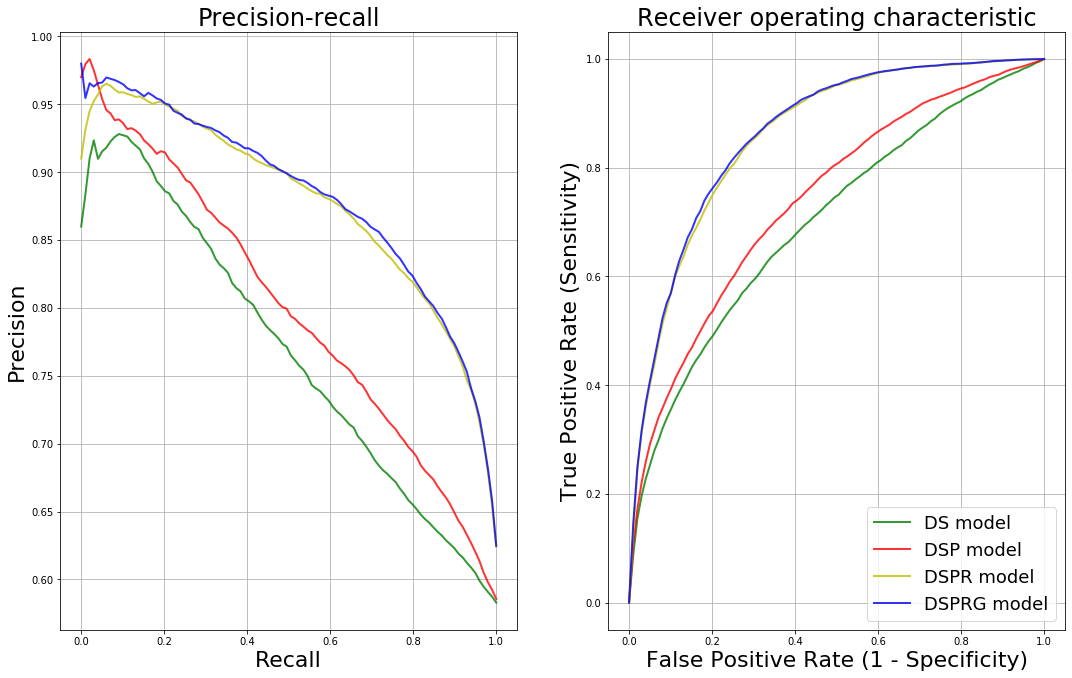

In [72]:
#running the 4 different models
fig, axs = plt.subplots(1, 2)
dem_soc_result, dem_soc_perm = modelfit(dem_soc_df, classifier, cv, color = 'g', label = r"DS model")
dem_soc_pers_result, dem_soc_pers_perm = modelfit(dem_soc_pers_df, classifier, cv, color = 'r', label = r"DSP model")
dem_soc_pers_rad_result, dem_soc_pers_rad_perm = modelfit(dem_soc_pers_rad_df, classifier, cv, color = 'y', label = r"DSPR model")
dem_soc_pers_rad_group_result, dem_soc_pers_rad_group_perm = modelfit(dem_soc_pers_rad_group_df, classifier, cv, color = 'b', label = r"DSPRG model")


(Precision-Recall AUC = 0.89, SD = 0.03)
(Receiver Operating Characteristics AUC = 0.87, SD = 0.02)


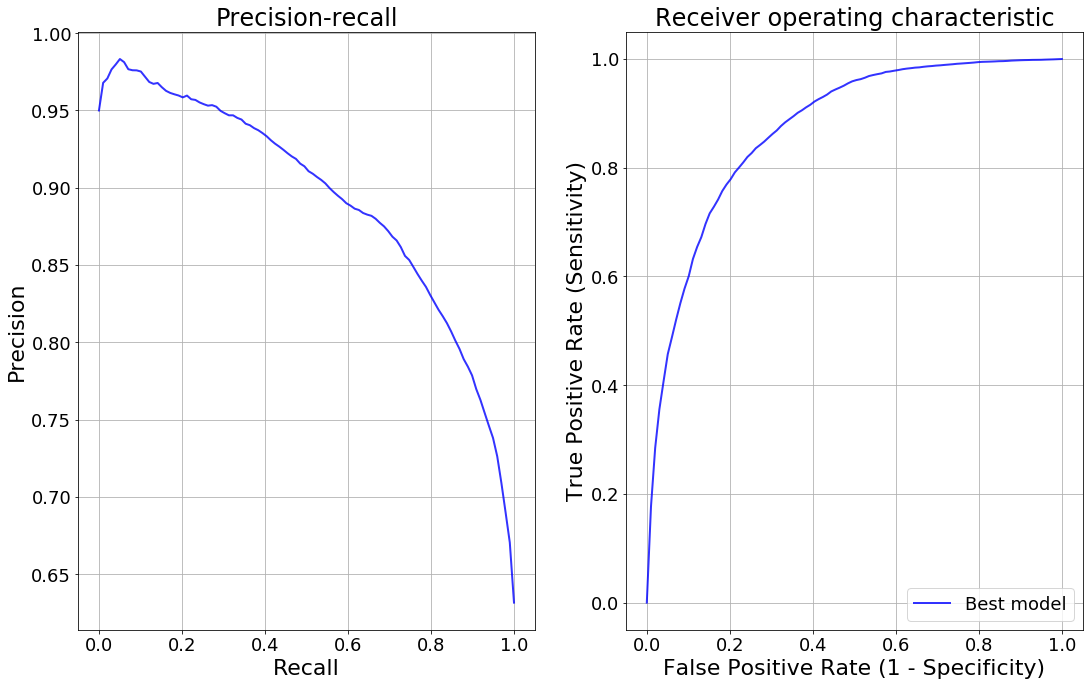

In [73]:
#running the model again only with the top predictors (with a mean permutation importance score > .001)

best_columns = dem_soc_pers_rad_group_perm[dem_soc_pers_rad_group_perm['Feature_mean'] > 0.001].index.values.tolist()
best_df = dem_soc_pers_rad_group_df[best_columns]
best_df.insert(0, 'Violent', prius_df['Violent'])
fig, axs = plt.subplots(1, 2)
best_result, _ = modelfit(best_df,classifier, cv, color = 'b', label = r"Best model")


In [74]:
"""
The model performed with the same AUC with only the most important variables identified earlier. 
To understand more extensively how these variables are statistically related to the outcome variable, 
chi-square tests were performed on the binarized categorical predictors, and t-tests on the continuous variables.
Risk ratios were calculated for the chi-square tests to measure the effect sizes.
Multiple comparisons were accounted for by applying Bonferroni-Holm corrections. 
Statistically significant predictors were stored for later visualization.
"""
cont_cols = ['Age', 'Time_US_Months', 'Children', 'Length_Group']

to_dummy_cols = [col for col in best_df.columns if len(best_df[col].value_counts()) > 2 and col not in cont_cols]
b = pd.get_dummies(best_df, columns = to_dummy_cols)
for col in to_dummy_cols:
    b.loc[best_df[col].isnull(), b.columns.str.startswith(col)] = np.nan

best_df = b.copy()

data_chi = pd.DataFrame(index = ['chi', 'p', 'odds', 'lowconf', 'highconf'], columns = [col for col in best_df.columns if col not in 'Violent'])
for col in data_chi.columns:
    if col in cont_cols:
        violent = best_df.where(best_df.Violent == 1)[col].dropna()
        nonviolent = best_df.where(best_df.Violent == 0)[col].dropna()
        data_chi.loc[['chi'], [col]] = stats.ttest_ind(violent, nonviolent)[0]
        data_chi.loc[['p'], [col]] = stats.ttest_ind(violent, nonviolent)[1]
    else:
        crosstab = pd.crosstab(best_df['Violent'], best_df[col])
        data_chi.loc[['chi', 'p'], [col]] = stats.chi2_contingency(crosstab)[0]
        data_chi.loc[['p'], [col]] = stats.chi2_contingency(crosstab)[1]
        data_chi.loc[['odds'], [col]] = contingency_tables.Table2x2(crosstab).riskratio
        data_chi.loc[['lowconf'], [col]] = contingency_tables.Table2x2(crosstab).riskratio_confint()[0]
        data_chi.loc[['highconf'], [col]] = contingency_tables.Table2x2(crosstab).riskratio_confint()[1]

variables = {}
data_chi = data_chi.transpose()
variables['unadjusted_p'] = data_chi[data_chi['p'] < 0.05].index.values.tolist()
data_chi['holm_adjusted_p'] = multipletests(data_chi['p'], alpha = 0.05, method = 'holm')[1]
variables['holm_adjusted_p'] = data_chi[data_chi['holm_adjusted_p'] < 0.05].index.values.tolist()


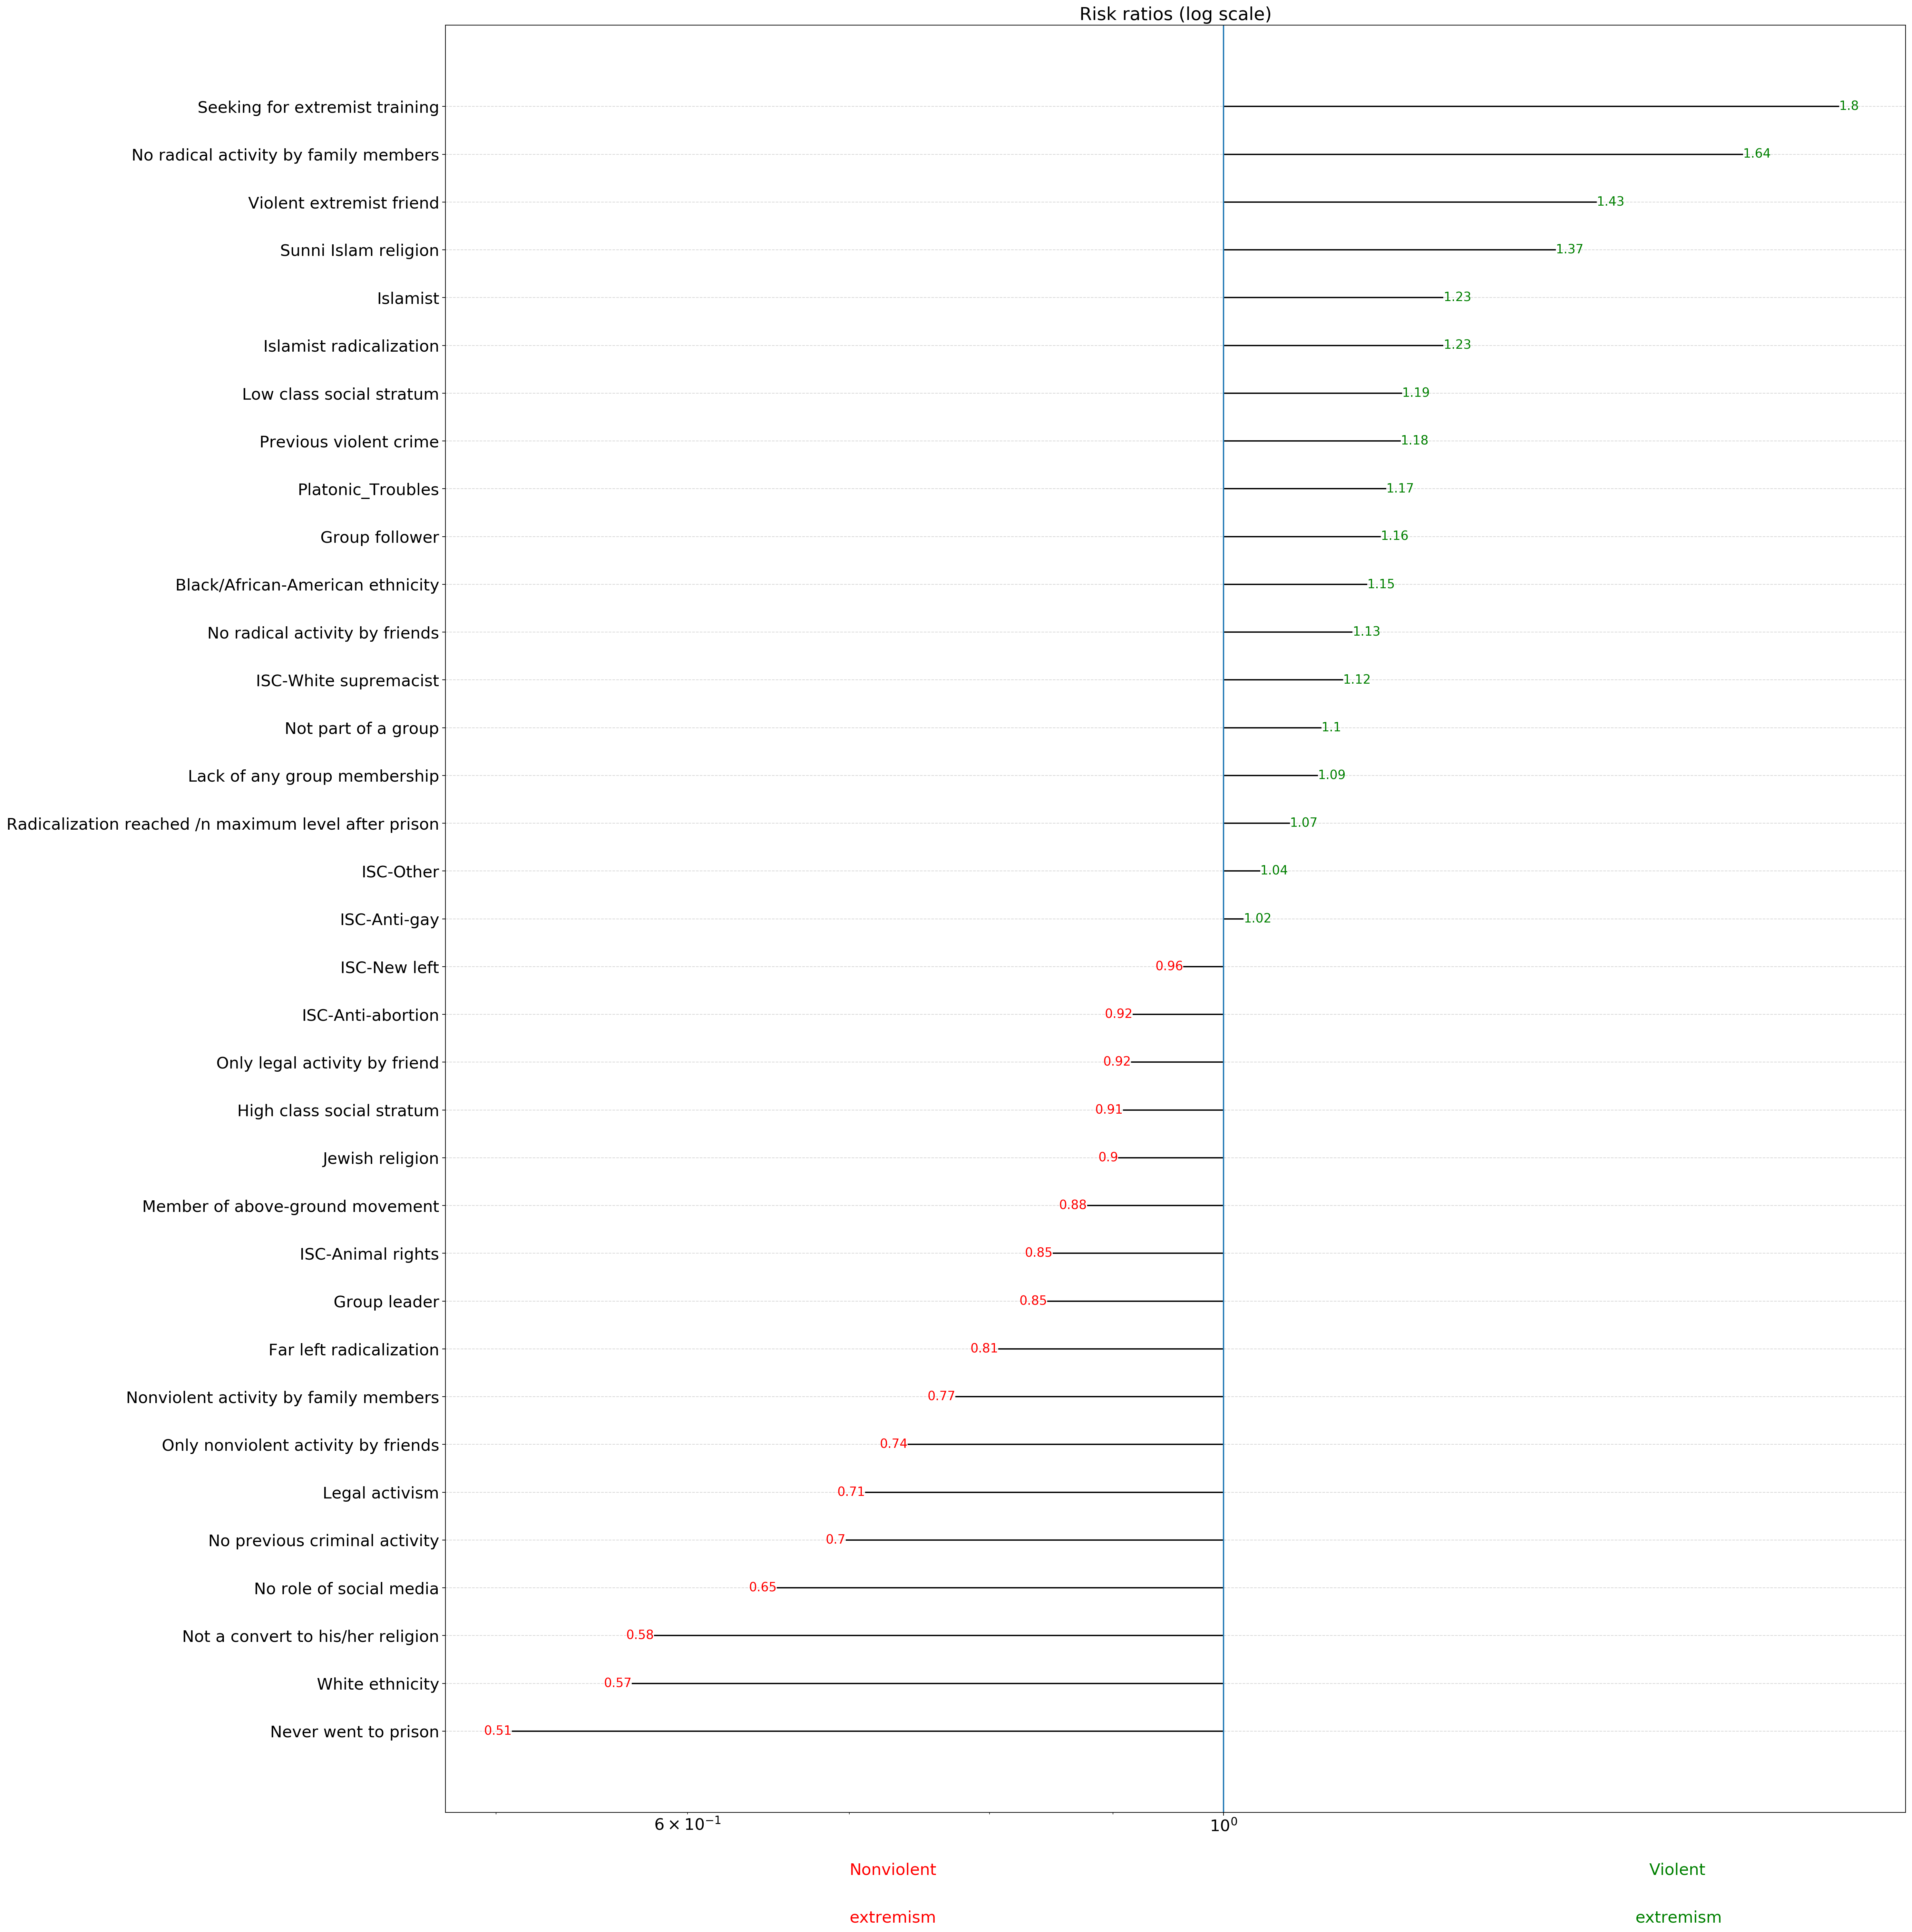

In [79]:
"""
Visualizing risk ratios of the most important and statistically significant predictors of violent and nonviolent extremism.
"""

chi_square_vis_df = data_chi.copy()
chi_square_vis_df = chi_square_vis_df[chi_square_vis_df['holm_adjusted_p'] < 0.05]

rename_dict = {"Radicalization_Islamist": "Islamist radicalization","Radical_Behaviors_5.0":"Legal activism",
                "Radicalization_Far_Left":"Far left radicalization","Radical_Behaviors_8.0": "Seeking for extremist training", 
                'Ideological_Sub_Category1_2':'ISC-White supremacist','Ideological_Sub_Category1_6':'ISC-Animal rights',
                'Ideological_Sub_Category1_11': 'Islamist','Ideological_Sub_Category1_15':'ISC-Anti-abortion', 
                'Ideological_Sub_Category1_7':'ISC-New left', 'Ideological_Sub_Category1_17':'ISC-Anti-gay', 'Ideological_Sub_Category1_18':'ISC-Other',
                "Broad_Ethnicity_2.0":"Black/African-American ethnicity", "Broad_Ethnicity_3.0":"White ethnicity",
                "Radical_Friend_0.0":"No radical activity by friends","Radical_Friend_1.0": 'Only legal activity by friend',
                "Radical_Friend_2.0":"Only nonviolent activity by friends",
                "Radical_Friend_3.0":"Violent extremist friend",
                'Religious_Background_1.0':'Sunni Islam religion','Religious_Background_12.0': 'Jewish religion',
                'Prison_Radicalize_0.0': 'Never went to prison','Prison_Radicalize_3.0': 'Radicalization reached /n maximum level after prison' ,
                "Radical_Family_0.0":"No radical activity by family members","Radical_Family_2.0":"Nonviolent activity by family members",
                'Group_Membership_0':'Lack of any group membership', 'Group_Membership_1':'Member of above-ground movement',
                "Role_Group_0.0": "Not part of a group","Role_Group_2.0": "Group follower", "Role_Group_3.0": "Group leader",
                "Social_Media_0.0" : "No role of social media", "Convert_0.0": "Not a convert to his/her religion",
                "Previous_Criminal_Activity_0.0" : "No previous criminal activity", "Previous_Criminal_Activity_3.0": "Previous violent crime",
                "Social_Stratum_Adulthood_1.0": "Low class social stratum", "Social_Stratum_Adulthood_3.0" : "High class social stratum"                
 }
chi_square_vis_df.rename(rename_dict, inplace = True)
chi_square_vis_df.sort_values('odds', inplace = True)
x = chi_square_vis_df.loc[:, ['odds']]
chi_square_vis_df['colors'] = ['red' if x < 1 else 'green' for x in chi_square_vis_df['odds']]

plt.figure(figsize=(30,30), dpi = 200)
plt.hlines(y=chi_square_vis_df.index, xmin = 1, xmax = chi_square_vis_df.odds)
for x, y, tex in zip(chi_square_vis_df.odds, chi_square_vis_df.index, chi_square_vis_df.odds):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 1 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 1 else 'green', 'size':14})
plt.yticks(chi_square_vis_df.index, fontsize=18)
#plt.xticks(list(range(-6, 3)))
plt.xscale("log")
plt.text(0.7, -3, 'Nonviolent', fontsize = 18, color = 'red')
plt.text(0.7, -4, 'extremism', fontsize = 18, color = 'red')
plt.text(1.5, -3, 'Violent',fontsize = 18, color = 'green')
plt.text(1.48, -4, 'extremism',fontsize = 18, color = 'green')
plt.title('Risk ratios (log scale)', fontdict={'size':20}) 
plt.grid(linestyle='--', alpha=0.5)
plt.axvline(x = 1)

plt.tight_layout()
plt.show()
